In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [7]:
# Redefining the model to match the expected state_dict keys
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # It seems the saved model used a single sequential layer named 'net'
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Adding the fully connected layers within the same sequential block
            nn.Flatten(), # Flatten the output from the convolutional layers
            nn.Linear(64 * 32 * 32, 128), # Assuming input image size was 128x128, after two maxpools of size 2, spatial dimensions become 32x32
            nn.ReLU(inplace=True),
            nn.Linear(128, 2),
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [8]:
# Loading model and weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
model.load_state_dict(torch.load("deepfake_cnn_weights.pth", map_location=device))
model.eval()

SimpleCNN(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=128, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [20]:
def run_grad_cam(model, img_path, target_layer, transform, device, class_names=None):
    import numpy as np
    import torch
    import cv2
    import matplotlib.pyplot as plt
    from PIL import Image

    feature_maps = []
    gradients = []

    # Hook functions
    def forward_hook(module, input, output):
        feature_maps.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Register hooks
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # Load image and preprocess
    image = Image.open(img_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Forward + backward
    model.eval()
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    model.zero_grad()
    output[0, pred_class].backward()

    # Grad-CAM calculation
    grads = gradients[0].cpu().detach().numpy()[0]
    acts = feature_maps[0].cpu().detach().numpy()[0]
    weights = np.mean(grads, axis=(1, 2))
    cam = np.zeros(acts.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * acts[i]

    cam = np.maximum(cam, 0)
    cam -= cam.min()
    cam /= cam.max()
    cam = cv2.resize(cam, (128, 128))

    # Overlay on original image
    img_np = np.array(image.resize((128, 128))) / 255.0
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET) / 255.0
    overlay = 0.5 * heatmap + 0.5 * img_np

    # Predicted label
    pred_label = class_names[pred_class] if class_names else str(pred_class)

    # Plot
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Predicted: {pred_label}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img_np)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(cam, cmap='jet')
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    return pred_label


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


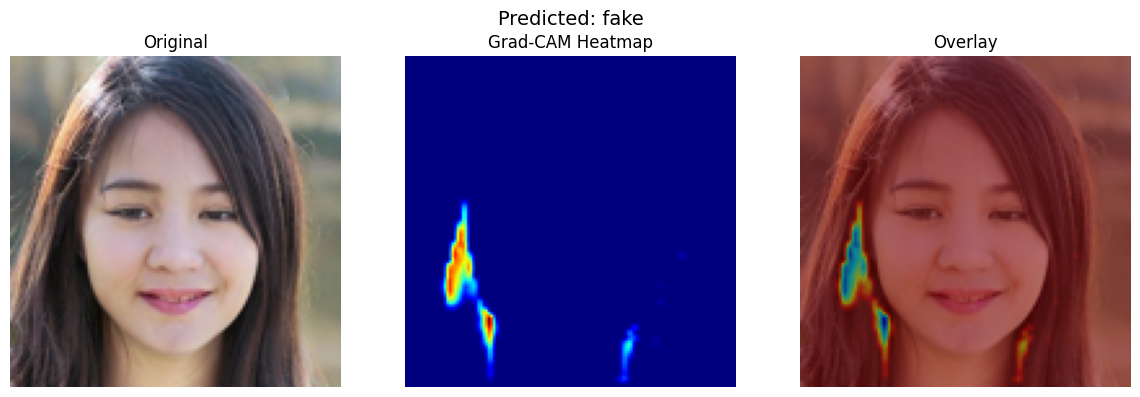

Predicted: fake


In [27]:
# Define class names
class_names = ['real', 'fake']

# Call the function
predicted_label = run_grad_cam(
    model=model,
    img_path="/content/00276TOPP4.jpg",
    target_layer=model.net[3],
    transform=transform,
    device=device,
    class_names=class_names
)

print("Predicted:", predicted_label)
